In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, Dense, Conv2DTranspose, BatchNormalization, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

2023-05-28 12:36:53.857897: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 12:36:54.035031: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-28 12:36:54.035916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 12:36:54.834397: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


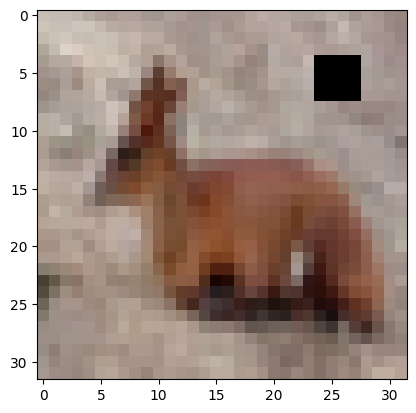

In [2]:
#Loading Cifar10 Data
def cifar10(X):
    with open(X, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

#Creating image array from Cifer10
def img(X):
    X = cifar10(X)
    X = X[b'data']/255
    X = X.reshape(X.shape[0],3,32,32)
    return X.transpose(0,2,3,1)

#Creating images with dark spot
def spot(X):
    Y = img(X)
    A = np.ones(Y.shape[0]*8*8*3,dtype=int)
    B = np.arange(0,Y.shape[0]*8*8*3,64)
    C = np.random.randint(0,32,Y.shape[0])
    C = np.kron(C, np.ones(3,dtype=int))
    C = B + C
    A[C] = 0
    A = A.reshape([Y.shape[0],3,8,8])
    A = np.kron(A, np.ones((4,4)))
    A = A.transpose(0,2,3,1)
    A = A*Y
    return A

#Loading train data
def load_train(X):
    A = img(X + 'data_batch_1')
    for i in range(2,6):
        A = np.concatenate((A,img(X + 'data_batch_' + str(i))))
    B = spot(X + 'data_batch_1')
    for i in range(2,6):
        B = np.concatenate((B,spot(X + 'data_batch_' + str(i))))
    return A,B

#Loading test data
def load_test(X):
    A = img(X + 'test_batch')
    B = spot(X + 'test_batch')
    return A,B

path = '/home/deb/cifar-10-batches-py/'
X_train, Y_train = load_train(path)
X_test, Y_test = load_test(path)
plt.imshow(Y_train[1004])

In [3]:
#Encoder
_input_ = Input(shape = (32, 32, 3))
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(_input_)
layer = BatchNormalization()(layer)
layer = MaxPool2D(pool_size = (2,2), padding = 'same')(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = MaxPool2D(pool_size = (2,2), padding = 'same')(layer)

#Decoder
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = UpSampling2D()(layer)
layer = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(layer)
layer = BatchNormalization()(layer)
layer = UpSampling2D()(layer)
_output_ = Conv2D(3, (3,3), activation = 'sigmoid', padding = 'same')(layer)

autoencoder = Model(_input_,_output_,name = 'Spot_Remover_Autoencoder')
autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

cp = ModelCheckpoint('Spot_Remover_Autoencoder.h5', save_best_only = True, save_weights_only = False, verbose = 1)
network = autoencoder.fit(Y_train, X_train, batch_size = 128, epochs =30, callbacks = cp, validation_split = 0.25, verbose = 2)

2023-05-28 12:37:14.566066: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 460800000 exceeds 10% of free system memory.


Epoch 1/30


2023-05-28 12:37:15.164023: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 460800000 exceeds 10% of free system memory.
2023-05-28 12:38:02.843895: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.
2023-05-28 12:38:03.174738: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 153600000 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 0.59593, saving model to Spot_Remover_Autoencoder.h5
293/293 - 51s - loss: 0.5776 - val_loss: 0.5959 - 51s/epoch - 173ms/step
Epoch 2/30

Epoch 2: val_loss improved from 0.59593 to 0.56356, saving model to Spot_Remover_Autoencoder.h5
293/293 - 50s - loss: 0.5624 - val_loss: 0.5636 - 50s/epoch - 169ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.56356 to 0.56066, saving model to Spot_Remover_Autoencoder.h5
293/293 - 46s - loss: 0.5598 - val_loss: 0.5607 - 46s/epoch - 158ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.56066 to 0.55952, saving model to Spot_Remover_Autoencoder.h5
293/293 - 46s - loss: 0.5583 - val_loss: 0.5595 - 46s/epoch - 157ms/step
Epoch 5/30

Epoch 5: val_loss improved from 0.55952 to 0.55861, saving model to Spot_Remover_Autoencoder.h5
293/293 - 46s - loss: 0.5574 - val_loss: 0.5586 - 46s/epoch - 156ms/step
Epoch 6/30

Epoch 6: val_loss improved from 0.55861 to 0.55782, saving model to Spot_Remover_Autoencoder.h5
29

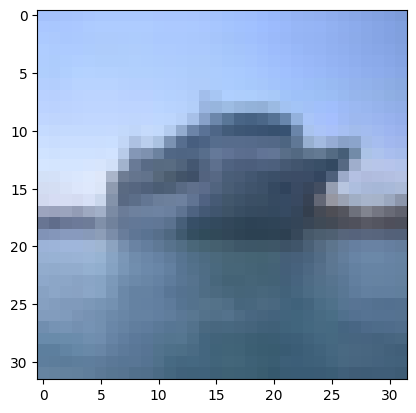

In [4]:
autoencoder = load_model('Spot_Remover_Autoencoder.h5')
plt.imshow(X_test[1004])

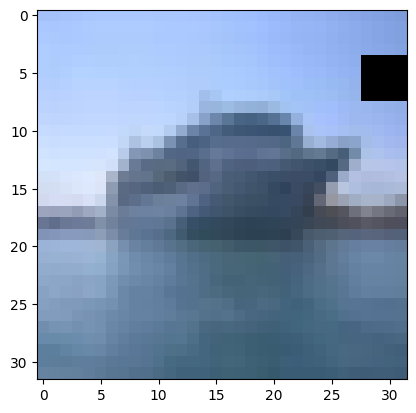

In [5]:
plt.imshow(Y_test[1004])

In [6]:
pred = autoencoder.predict(Y_test)
pred.shape

  1/313 [..............................] - ETA: 36s

2023-05-28 13:05:13.931555: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 [==============================] - 4s 12ms/step


(10000, 32, 32, 3)

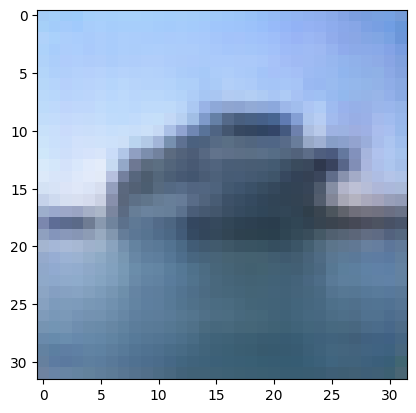

In [7]:
plt.imshow(pred[1004])

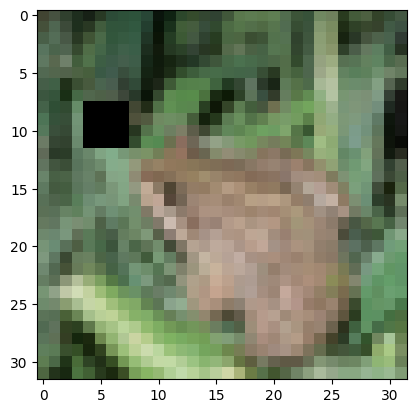

In [8]:
plt.imshow(Y_test[4])

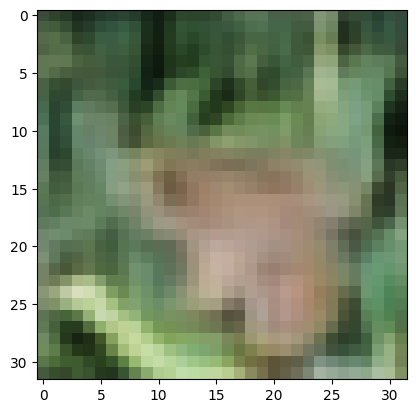

In [9]:
plt.imshow(pred[4])